In [95]:
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

df= pd.read_csv('data/car_price_prediction_.csv')
df = df.drop('Car ID', axis = 1)

In [96]:
from sklearn.preprocessing import StandardScaler

# Select the numerical columns
numerical_cols = ['Year', 'Engine Size', 'Mileage']

# Initialize the Standard Scaler
scaler = StandardScaler()

# Apply the scaler to the numerical columns
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [97]:
from scipy import stats
import numpy as np

# Define the threshold for outlier detection
z_thresh = 3

# Select the numerical columns
numerical_cols = ['Year', 'Engine Size', 'Mileage', 'Price']

# Calculate the Z-scores for the selected columns
z_scores = np.abs(stats.zscore(df[numerical_cols]))

# Create a boolean mask to filter out outliers based on Z-score threshold
outliers = (z_scores > z_thresh).any(axis=1)

# Filter out the outliers
df_cleaned = df[~outliers]

# Print the remaining dataset
print(df_cleaned.shape)


(2500, 9)


In [98]:
X = df.drop('Price', axis = 1)
Y = df['Price']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.7, random_state = 42)


In [110]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df["Brand"] = le.fit_transform(df["Brand"])
le = LabelEncoder()
df["Fuel Type"] = le.fit_transform(df["Fuel Type"])
le = LabelEncoder()
df["Transmission"] = le.fit_transform(df["Transmission"])
le = LabelEncoder()
df["Condition"] = le.fit_transform(df["Condition"])
le = LabelEncoder()
df["Model"] = le.fit_transform(df["Model"])
df.head()

,Brand,Year,Engine Size,Fuel Type,Transmission,Mileage,Condition,Price,Model
0,5,0.625610,-0.813848,3,1,-0.397234,1,26613.92,19
1,1,0.911720,0.652872,1,1,-0.074626,2,14679.61,1
2,0,0.196444,0.722716,1,1,0.362347,1,44402.61,3
3,5,-0.089667,0.443340,0,0,-0.922249,1,86374.33,20
4,2,-0.375778,-0.604316,0,1,0.833415,0,73577.10,21


In [100]:
'''
# Divide the numerical categories
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns.tolist()[:-1]

# Divide the categorical categories
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

# Instantiate the scaler
numerical_transformer = StandardScaler()

# Instantiate the one-hot encoder
categorical_transformer = OneHotEncoder(drop='first')
'''

"\n# Divide the numerical categories\nnumerical_features = df.select_dtypes(include=['float64', 'int64']).columns.tolist()[:-1]\n\n# Divide the categorical categories\ncategorical_features = df.select_dtypes(include=['object']).columns.tolist()\n\n# Instantiate the scaler\nnumerical_transformer = StandardScaler()\n\n# Instantiate the one-hot encoder\ncategorical_transformer = OneHotEncoder(drop='first')\n"

In [101]:
preprocesor = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

model = Pipeline(
    steps = [
        ('preprocesor', preprocesor),
        ('regresor', LinearRegression())
    ]
)

In [102]:
# Im going to train my model and store my predictions

model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)

In [103]:

print(f'''
Metrics:
RMSE: {np.sqrt(mean_squared_error(Y_pred, Y_test))},
MSE: {mean_squared_error(Y_pred, Y_test)}
R2: {r2_score(Y_test, Y_pred)}
''')

mae_test = mean_absolute_error(Y_test, Y_pred)
print("Mean Absolute Error on test data:", mae_test)


Metrics:
RMSE: 27828.565634151106,
MSE: 774429065.254256
R2: -0.022738580424332522

Mean Absolute Error on test data: 24051.706747123953


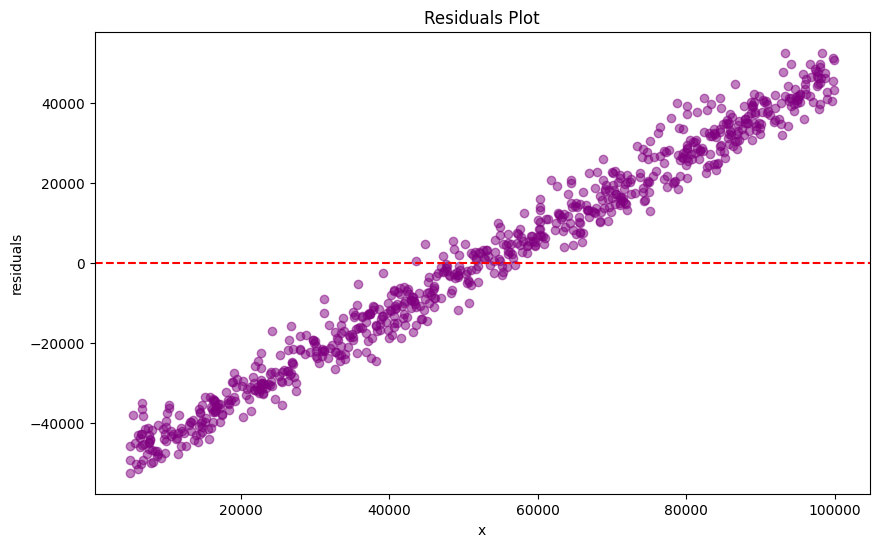

In [104]:
residuals = Y_test - Y_pred
residuals = residuals.values

plt.figure(figsize=(10, 6))
plt.scatter(Y_test, residuals, color = 'purple', alpha = 0.5)
plt.axhline(y = 0, color = 'red', linestyle ='--')
plt.title('Residuals Plot')
plt.xlabel('x')
plt.ylabel('residuals')

plt.show()


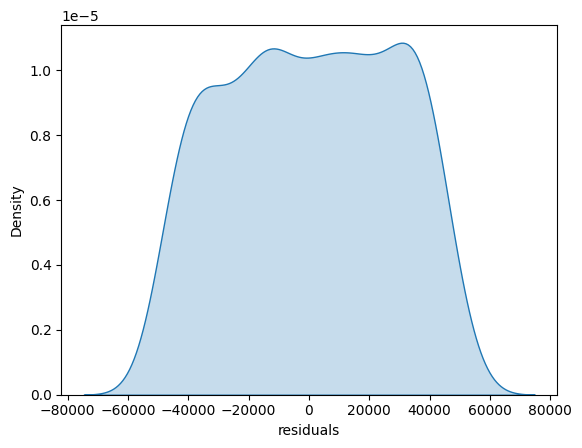

I like how our residuals perform in this graph, its very close from a normal distribution


In [105]:
res_df = pd.DataFrame({'residuals':residuals})
sns.kdeplot(res_df, x = 'residuals', fill=True)
plt.show()
print("I like how our residuals perform in this graph, its very close from a normal distribution")

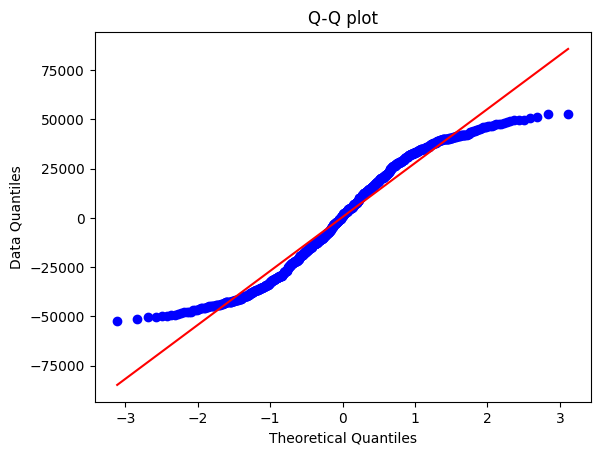

Our Q-Q plot looks pretty good, its very likely our dataset will follow a normal distribution


In [106]:
(osm, osr), (slope, intercept, r) = stats.probplot(residuals, dist='norm', plot = plt)
plt.title('Q-Q plot')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Data Quantiles')
plt.show()
print("Our Q-Q plot looks pretty good, its very likely our dataset will follow a normal distribution")

In [107]:
# Perform the Shapiro-Wilk test on the residuals
statistic, p_value = stats.shapiro(residuals)

# Print the test statistic
print(f'Statistic: {statistic}')
# Print the p-value from the test
print(f'p-value: {p_value}')

# Set the significance level (alpha) to 0.05
alpha = 0.05

# Check the result of the test against the significance level
if p_value <= alpha:
    # If p-value is less than or equal to 0.05, we reject the null hypothesis
    print('We reject the null hypothesis. The data does not follow a normal distribution.')
else:
    # If p-value is greater than 0.05, we fail to reject the null hypothesis
    print('We fail to reject the null hypothesis. The data might follow a normal distribution.')
    


Statistic: 0.9598296284675598
p-value: 1.8168344433078243e-13
We reject the null hypothesis. The data does not follow a normal distribution.


In [108]:


# Calculate the mean of Y (target variable)
mean_y = Y_test.mean()

# Calculate the percentage of MAE relative to the mean of Y
mae_percentage = (mae_test / mean_y) * 100

print(f"The Mean Absolute Error is {mae_test:.2f}, which is {mae_percentage:.2f}% of the mean of Y.")
print(f"This means if our model makes a prediction it'll be +-{mae_percentage:.2f}% trustworthy")

The Mean Absolute Error is 24051.71, which is 45.43% of the mean of Y.
This means if our model makes a prediction it'll be +-45.43% trustworthy


In [111]:
df.columns.tolist()

['Brand',
 'Year',
 'Engine Size',
 'Fuel Type',
 'Transmission',
 'Mileage',
 'Condition',
 'Price',
 'Model']